In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle

In [6]:
dataCSV = "../app/streamData/producer/dataset/Bitcoin_USD_(01-05.2024).csv"
bitcoinData = pd.read_csv(dataCSV) 

In [7]:
bitcoinData = bitcoinData.dropna()

In [8]:
bitcoinData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 0 to 121
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       121 non-null    object 
 1   Open       121 non-null    float64
 2   High       121 non-null    float64
 3   Low        121 non-null    float64
 4   Close      121 non-null    float64
 5   Adj Close  121 non-null    float64
 6   Volume     121 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.6+ KB


In [9]:
#change date type into timestamp
bitcoinData['Date'] = pd.to_datetime(bitcoinData['Date'], format='%Y-%m-%d')

In [10]:
bitcoinData.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-01,42280.234375,44175.437500,42214.976563,44167.332031,44167.332031,1.842698e+10
1,2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,44957.968750,3.933527e+10
2,2024-01-03,44961.601563,45503.242188,40813.535156,42848.175781,42848.175781,4.634232e+10
3,2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,3.044809e+10
4,2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,3.233603e+10
5,2024-01-06,44178.953125,44227.632813,43475.156250,43989.195313,43989.195313,1.609250e+10
6,2024-01-07,43998.464844,44495.570313,43662.230469,43943.097656,43943.097656,1.933057e+10
7,2024-01-08,43948.707031,47218.000000,43244.082031,46970.503906,46970.503906,4.274619e+10
8,2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,3.982129e+10
9,2024-01-10,46121.539063,47647.222656,44483.152344,46627.777344,46627.777344,5.011461e+10


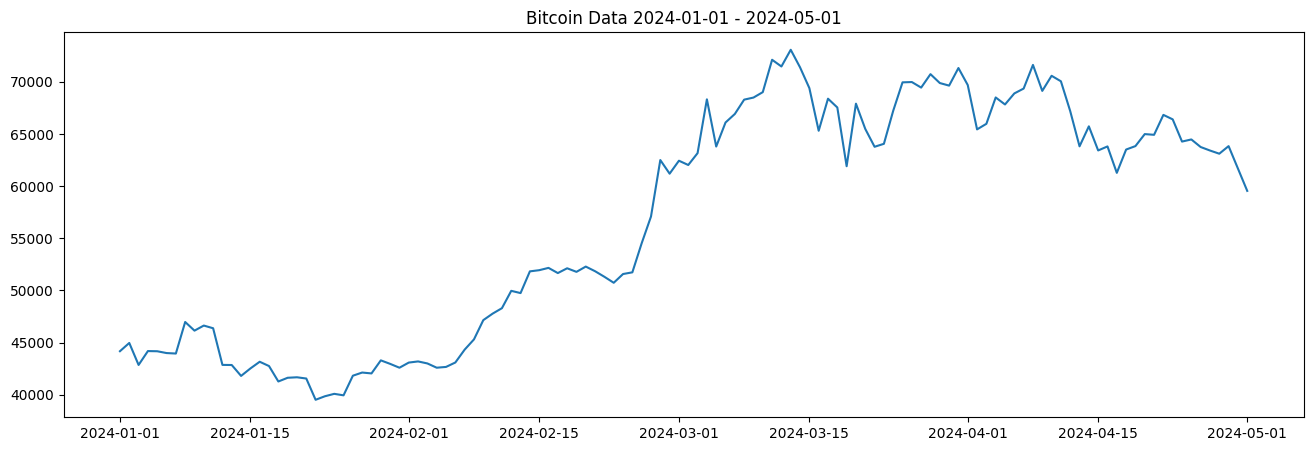

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(bitcoinData['Date'], bitcoinData['Close'])
plt.title("Bitcoin Data 2024-01-01 - 2024-05-01")
plt.show()

# ML Model

In [12]:
newBitcoinData = bitcoinData[['Date','Close']]
newBitcoinData['Close'] = newBitcoinData['Close'].round(2)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16196\2087585495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newBitcoinData['Close'] = newBitcoinData['Close'].round(2)


In [13]:
newBitcoinData.head()


,Date,Close
0,2024-01-01,44167.33
1,2024-01-02,44957.97
2,2024-01-03,42848.18
3,2024-01-04,44179.92
4,2024-01-05,44162.69


In [14]:
# Feature engineering
newBitcoinData['Day'] = newBitcoinData['Date'].dt.day
newBitcoinData['Month'] = newBitcoinData['Date'].dt.month
newBitcoinData['Year'] = newBitcoinData['Date'].dt.year

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16196\2964787785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newBitcoinData['Day'] = newBitcoinData['Date'].dt.day
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16196\2964787785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newBitcoinData['Month'] = newBitcoinData['Date'].dt.month
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16196\2964787785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [15]:
# newBitcoinData['Date_Unix'] = bitcoinData['Date'].astype('int64')
x = newBitcoinData[['Day', 'Month', 'Year']]
y = newBitcoinData['Close']

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=10, test_size = 0.3)

In [16]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")

print(f"x test shape: {x_test.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (84, 3)
y train shape: (84,)
x test shape: (37, 3)
y test shape: (37,)


# Random Forest

In [17]:
forest_parameters = {'n_estimators':[100, 200, 300, 400, 500],
                     'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     'min_samples_split':[2,4,6,8,10],
                     'min_samples_leaf':[1,3,5,7,9],
                     'max_features': ['sqrt', 'log2', None]
                }

grid = RandomizedSearchCV(RandomForestRegressor(),
                   forest_parameters)

grid.fit(x_train, y_train)
print('best estimator: {}'.format(grid.best_estimator_))
print('best parameters: {}'.format(grid.best_params_))
print('best score: {}'.format(grid.best_score_))

best estimator: RandomForestRegressor(max_depth=50, max_features=None, n_estimators=300)
best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50}
best score: 0.9669955951537925


In [18]:
random_forest = grid.best_estimator_.fit(x_train, y_train)
random_forest_predict = random_forest.predict(x_test)

In [19]:
random_forest_r2_score = r2_score(y_test, random_forest_predict)
random_forest_mae = mean_absolute_error(y_test, random_forest_predict)

print('Random Forest Regressor Accuracy: {}'.format(random_forest_r2_score))
print('Random Forest Regressor MAE: {}'.format(random_forest_mae))

Random Forest Regressor Accuracy: 0.9743804629585641
Random Forest Regressor MAE: 1162.201340540578


# PLot Prediction

In [20]:
pred = random_forest.predict(x)

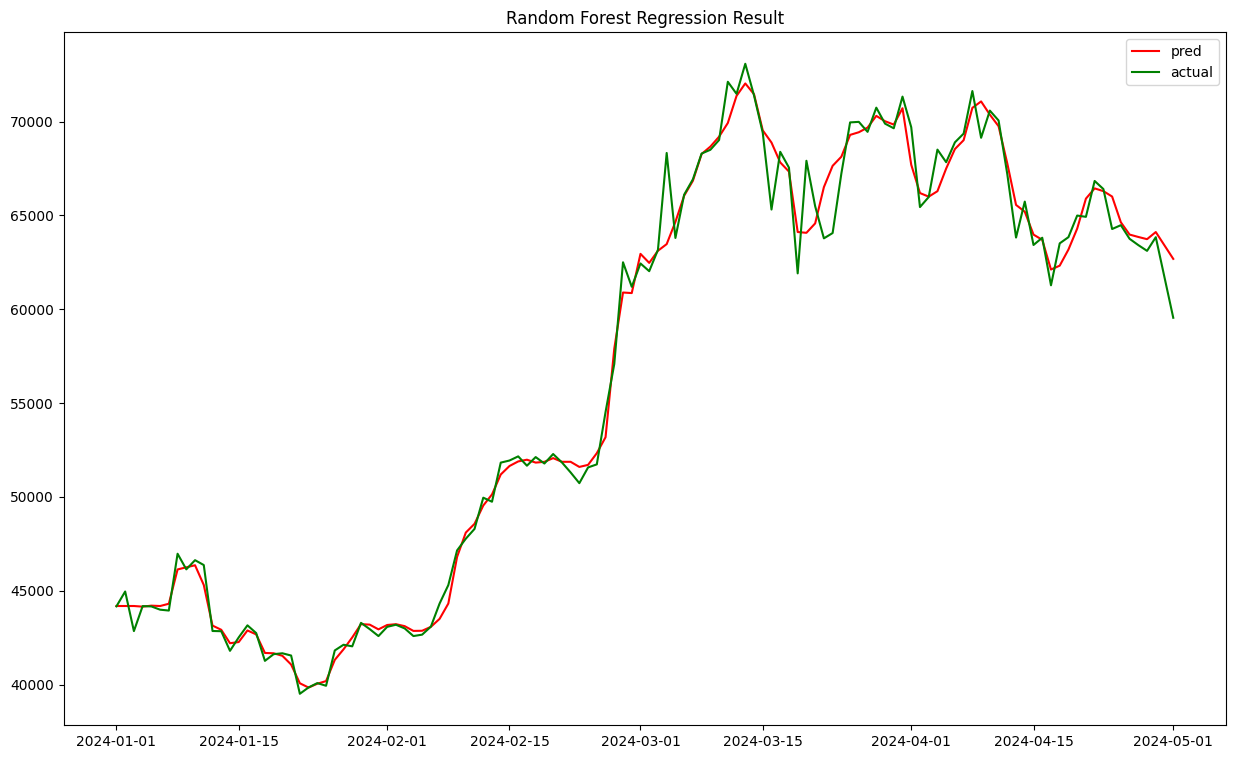

In [21]:
plt.figure(figsize=(15,9))
plt.plot(newBitcoinData['Date'],pred,color='Red',label='pred')
plt.plot(newBitcoinData['Date'],newBitcoinData['Close'],color='Green',label='actual')
plt.title("Random Forest Regression Result")
plt.legend()
plt.show()

In [22]:
# Get the last date from the dataset
last_date = newBitcoinData['Date'].max()

# Generate the next 30 days
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 10)]

# future_features = pd.DataFrame({'Date': [future_date for future_date in future_dates]})
# Transform future dates into features
future_features = pd.DataFrame({
    'Date': [future_date for future_date in future_dates],
    'Day': [date.day for date in future_dates],
    'Month': [date.month for date in future_dates],
    'Year': [date.year for date in future_dates]
})

In [23]:
# Predict prices for the next 30 days
predicted_prices = random_forest.predict(future_features[['Day', 'Month', 'Year']])

In [24]:
future_features['Close'] = predicted_prices.round(2)

In [25]:
# Merge historical data with future data
combined_data = pd.concat([newBitcoinData,future_features ], ignore_index=True)

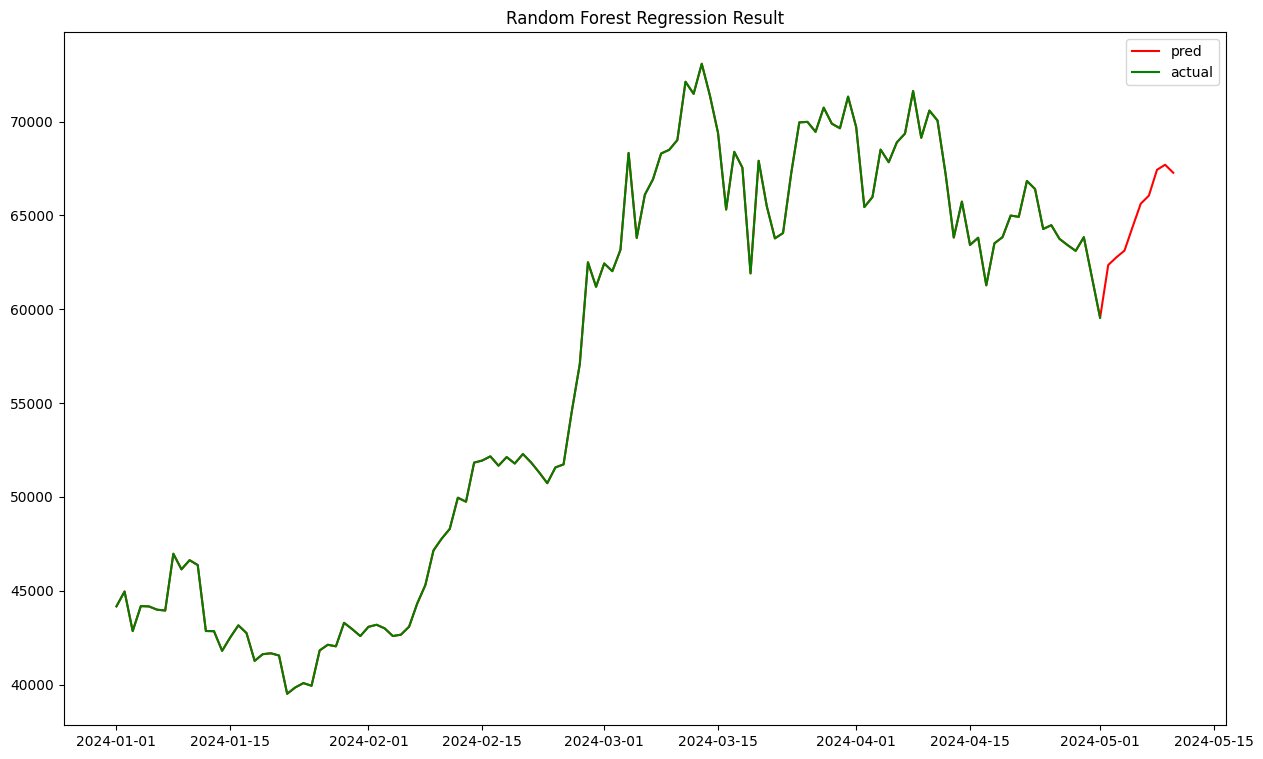

In [26]:
plt.figure(figsize=(15,9))
plt.plot(combined_data['Date'],combined_data['Close'],color='Red',label='pred')
plt.plot(newBitcoinData['Date'],newBitcoinData['Close'],color='Green',label='actual')
plt.title("Random Forest Regression Result")
plt.legend()
plt.show()

# Save Model

In [27]:
# Save the model
with open('../app/streamlit/random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest, file)

In [28]:
# Generate predictions
# input_data = newBitcoinData.set_index('Date', inplace=True)
# predictions = []
# for _ in range(30):  # Predict 30 future steps
#     pred = random_forest.predict(newBitcoinData[['Date']])
#     # print(pred)
#     predictions.append(pred)
    # # Update input data
    # input_data = np.append(input_data[:, 1:, :], [[pred]], axis=1)